In [26]:
import os
from pathlib import Path
import logging
import numpy as np
import matplotlib.pyplot as plt
from scripts import losses
from scripts import sampling
from model_code import utils as mutils
from model_code.ema import ExponentialMovingAverage
from scripts import datasets
import torch
import wandb
from torch.utils import tensorboard
from scripts import utils
from absl import app
from absl import flags
from ml_collections.config_flags import config_flags
import matplotlib.pyplot as plt
from train import create_degrader
from scripts import sampling
from torchvision.utils import make_grid

In [27]:
workdir = "runs/1366776"

In [29]:
# get config
from configs.config_1355776 import get_config
config = get_config()

In [30]:
# load model
# Initialize model
model = mutils.create_model(config)
optimizer = losses.get_optimizer(config, model.parameters())
ema = ExponentialMovingAverage(
    model.parameters(), decay=config.model.ema_rate)
state = dict(optimizer=optimizer, model=model, step=0, ema=ema)
model_evaluation_fn = mutils.get_model_fn(model, train=False, sample=True if config.model.type == 'vae' else False)

# Create checkpoints directory
checkpoint_dir = os.path.join(workdir, "checkpoints")
# Intermediate checkpoints to resume training
checkpoint_meta_dir = os.path.join(
    workdir, "checkpoints-meta", "checkpoint.pth")
Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)
Path(os.path.dirname(checkpoint_meta_dir)).mkdir(
    parents=True, exist_ok=True)
# Resume training when intermediate checkpoints are detected
state = utils.restore_checkpoint(checkpoint_meta_dir, state, config.device)
initial_step = int(state['step'])

# Get the forward process definition
scales = config.model.blur_schedule
degrader = create_degrader(config)

delta = config.model.delta
initial_sample = sampling.get_zero_initial_sample(config)
scales = torch.tensor(config.model.blur_schedule, device=config.device)

Creating VAE model


In [31]:
initial_sample, original_image = sampling.get_initial_sample(config, degrader, delta, config.eval.batch_size)

In [25]:
#degrade upto t=0.5
t = torch.linspace(0, 1, original_image.shape[0], device=config.device)
degraded = degrader(original_image, t)
z = torch.randn(config.eval.batch_size, config.model.encoder.latent_dim, device=config.device)
result = model_evaluation_fn(degraded, None, t, z)

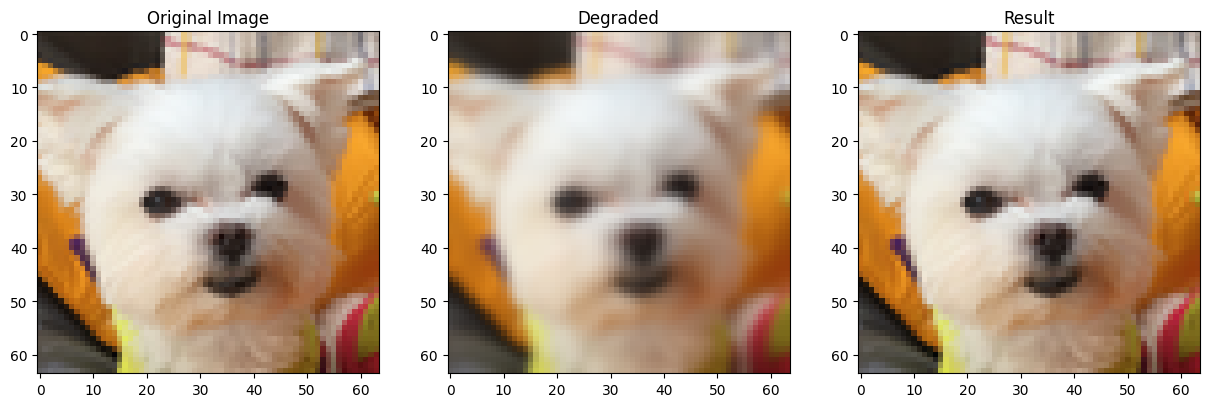

In [26]:
# plot degraded, original image, and result
i_image = 1
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(original_image[i_image].cpu().detach().numpy().transpose(1, 2, 0))
axs[0].set_title('Original Image')
axs[1].imshow(degraded[i_image].cpu().detach().numpy().transpose(1, 2, 0))
axs[1].set_title('Degraded')
axs[2].imshow(result[i_image].cpu().detach().numpy().transpose(1, 2, 0))
axs[2].set_title('Result')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


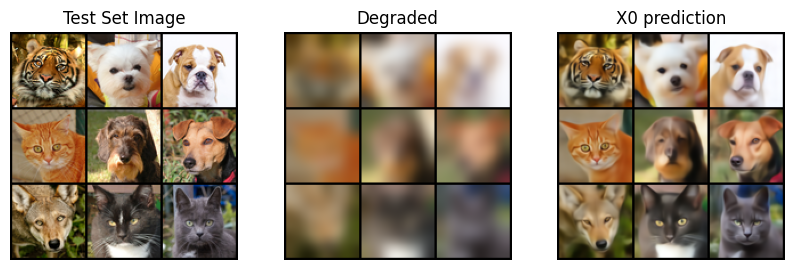

In [27]:
t = 0.5
t = torch.tensor([t], device=config.device)

degraded = degrader(original_image, t)
z = torch.randn(config.eval.batch_size, config.model.encoder.latent_dim, device=config.device)
reconstructed = model_evaluation_fn(degraded, None, t, z)

og_grid = make_grid(original_image, nrow=3)
degraded_grid = make_grid(degraded, nrow=3)
result_grid = make_grid(reconstructed, nrow=3)


# Plot all four images
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].imshow(og_grid.permute(1, 2, 0))
axs[0].set_title('Test Set Image')
axs[1].imshow(degraded_grid.permute(1, 2, 0))
axs[1].set_title('Degraded')
axs[2].imshow(result_grid.permute(1, 2, 0))
axs[2].set_title('X0 prediction')

# Hide the axis for all subplots
for ax in axs:
    ax.axis('off')
plt.show()

In [28]:
import torch
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from torchvision.utils import make_grid

def interactive_plot(t):
    # Assuming `config`, `degrader`, `model_evaluation_fn`, and `original_image` are already defined
    t_tensor = torch.tensor([t], device=config.device)

    degraded = degrader(original_image, t_tensor)

    # do the inference
    z = torch.randn(config.eval.batch_size, config.model.encoder.latent_dim, device=config.device)
    reconstructed = model_evaluation_fn(degraded, None, t_tensor, z)

    og_grid = make_grid(original_image, nrow=3)
    degraded_grid = make_grid(degraded, nrow=3)
    result_grid = make_grid(reconstructed, nrow=3)

    # Plot all three images
    fig, axs = plt.subplots(1, 3, figsize=(10, 3))
    axs[0].imshow(og_grid.permute(1, 2, 0).cpu().numpy())
    axs[0].set_title('Test Set Image')
    axs[1].imshow(degraded_grid.permute(1, 2, 0).cpu().numpy())
    axs[1].set_title('Degraded')
    axs[2].imshow(result_grid.permute(1, 2, 0).cpu().numpy())
    axs[2].set_title('X0 prediction')

    # Hide the axis for all subplots
    for ax in axs:
        ax.axis('off')

    plt.show()

# Interactive widget
interact(interactive_plot, t=FloatSlider(min=0.0, max=1.0, step=0.01, value=0.5))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

<function __main__.interactive_plot(t)>

In [29]:
import torch
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from torchvision.utils import make_grid

def interactive_plot(t):
    # Assuming `config`, `degrader`, `model_evaluation_fn`, and `original_image` are already defined
    t_tensor = torch.tensor([t], device=config.device)
    
    degraded = degrader(original_image, t_tensor)
    with torch.no_grad():
        # Perform inference three times
        reconstructed_images = []
        for _ in range(100):
            z = torch.randn(config.eval.batch_size, config.model.encoder.latent_dim, device=config.device)
            reconstructed = model_evaluation_fn(degraded, None, t_tensor, z)
            reconstructed_images.append(reconstructed)
        
        # Stack the reconstructed images, convert to grayscale and calculate the standard deviation
        # images shape: [Batch, Channel, Height, Width]
    
        reconstructed_stack = torch.stack(reconstructed_images)
        std_dev = torch.std(reconstructed_stack, dim=0)
    
    # Create image grids
    og_grid = make_grid(original_image, nrow=3)
    degraded_grid = make_grid(degraded, nrow=3)
    result_grid = make_grid(reconstructed_images[0], nrow=3)
    std_dev_grid = make_grid(std_dev, nrow=3)
    
    # Plot all four images
    fig, axs = plt.subplots(1, 4, figsize=(15, 3))
    axs[0].imshow(og_grid.permute(1, 2, 0).cpu().numpy())
    axs[0].set_title('Test Set Image')
    axs[1].imshow(degraded_grid.permute(1, 2, 0).cpu().numpy())
    axs[1].set_title('Degraded')
    axs[2].imshow(result_grid.permute(1, 2, 0).cpu().numpy())
    axs[2].set_title('X0 prediction')
    axs[3].imshow(std_dev_grid.permute(1, 2, 0).cpu().numpy(), vmin=std_dev_grid.min(), vmax=std_dev_grid.max())
    axs[3].set_title('Std Dev of Reconstructions')
    
    # Hide the axis for all subplots
    for ax in axs:
        ax.axis('off')
    
    plt.show()

# Interactive widget
interact(interactive_plot, t=FloatSlider(min=0.0, max=1.0, step=0.01, value=0.9))

interactive(children=(FloatSlider(value=0.9, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

<function __main__.interactive_plot(t)>

In [45]:
initial_sample, original_image = sampling.get_initial_sample(config, degrader, delta, config.eval.batch_size)

In [31]:
t = torch.linspace(0, 1, original_image.shape[0], device=config.device)
degraded = degrader(original_image, t)
z = torch.randn(config.eval.batch_size, config.model.encoder.latent_dim, device=config.device)
result = model_evaluation_fn(degraded, None, t, z)

In [32]:
config.model.K = 100
with torch.no_grad():
    # sampling
    # while any t is not zero
    x = degraded.clone()
    x0 = original_image.clone()
    while torch.any(t > 0):
        z = torch.randn(config.eval.batch_size, config.model.encoder.latent_dim, device=config.device)
        x0 = model_evaluation_fn(x, x0, t, None)
        x[t>0] = x[t>0] - degrader(x0[t>0], t[t>0]) + degrader(x0[t>0], t[t>0] - 1/config.model.K)
        t = t - 1/config.model.K
    sampling_image = x

KeyboardInterrupt: 

In [33]:
og_grid = make_grid(original_image, nrow=3)
degraded_grid = make_grid(degraded, nrow=3)
result_grid = make_grid(result, nrow=3)
sampling_grid = make_grid(sampling_image, nrow=3)

# Load the sampling image
sampling_image = sampling_grid

# Plot all four images
fig, axs = plt.subplots(1, 4, figsize=(10, 3))
axs[0].imshow(og_grid.permute(1, 2, 0))
axs[0].set_title('Test Set Image')
axs[1].imshow(degraded_grid.permute(1, 2, 0))
axs[1].set_title('Degraded')
axs[2].imshow(result_grid.permute(1, 2, 0))
axs[2].set_title(r'$x_0$ prediction')
axs[3].imshow(sampling_image.permute(1, 2, 0))
axs[3].set_title('Sampling Results')
# Hide the axis for all subplots
for ax in axs:
    ax.axis('off')
plt.show()

NameError: name 'sampling_image' is not defined

Repeat for K=10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


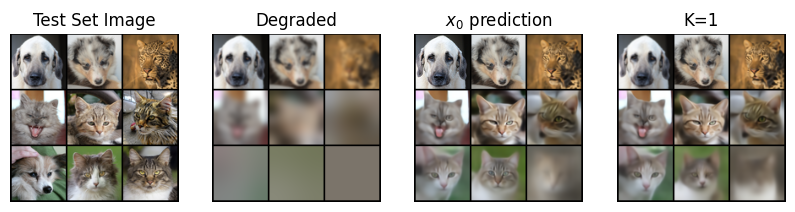

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


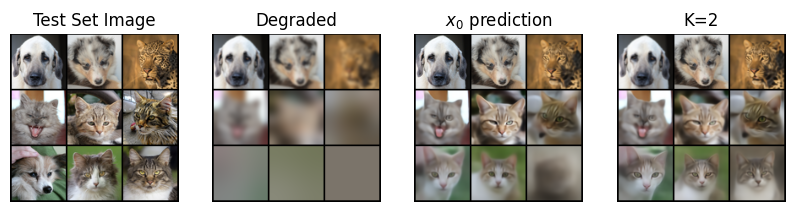

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


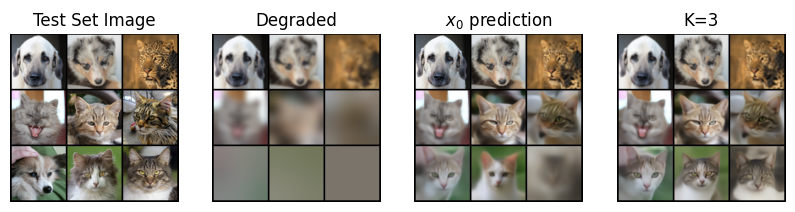

KeyboardInterrupt: 

In [34]:
for K in [1, 2, 3, 4, 5, 10, 20, 50, 100, 200]:
    t = torch.linspace(0, 1, original_image.shape[0], device=config.device)
    degraded = degrader(original_image, t)
    z = torch.randn(config.eval.batch_size, config.model.encoder.latent_dim, device=config.device)
    result = model_evaluation_fn(degraded, None, t, z)

    config.model.K = K
    with torch.no_grad():
        # sampling
        # while any t is not zero
        x = degraded.clone()
        x0 = original_image.clone()
        while torch.any(t > 0):
            z = torch.randn(config.eval.batch_size, config.model.encoder.latent_dim, device=config.device)
            x0 = model_evaluation_fn(x, x0, t, None)
            x[t>0] = x[t>0] - degrader(x0[t>0], t[t>0]) + degrader(x0[t>0], t[t>0] - 1/config.model.K)
            t = t - 1/config.model.K
        sampling_image = x

    og_grid = make_grid(original_image, nrow=3)
    degraded_grid = make_grid(degraded, nrow=3)
    result_grid = make_grid(result, nrow=3)
    sampling_grid = make_grid(sampling_image, nrow=3)

    # Load the sampling image
    sampling_image = sampling_grid

    # Plot all four images
    fig, axs = plt.subplots(1, 4, figsize=(10, 3))
    axs[0].imshow(og_grid.permute(1, 2, 0))
    axs[0].set_title('Test Set Image')
    axs[1].imshow(degraded_grid.permute(1, 2, 0))
    axs[1].set_title('Degraded')
    axs[2].imshow(result_grid.permute(1, 2, 0))
    axs[2].set_title(r'$x_0$ prediction')
    axs[3].imshow(sampling_image.permute(1, 2, 0))
    axs[3].set_title('Sampling Results')
    # Hide the axis for all subplots
    for ax in axs:
        ax.axis('off')
    plt.title(f'K={K}')
    plt.show()

Resampled z
tensor(0.)


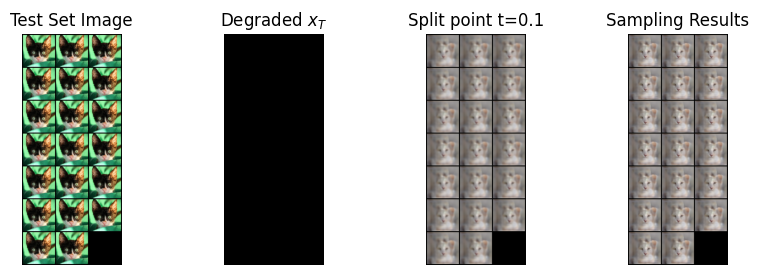

tensor(5.4600e-06)


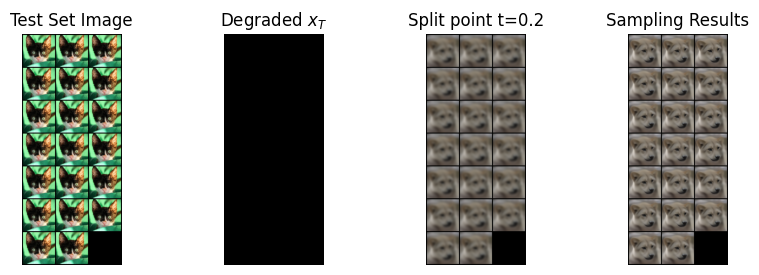

tensor(2.1202e-05)


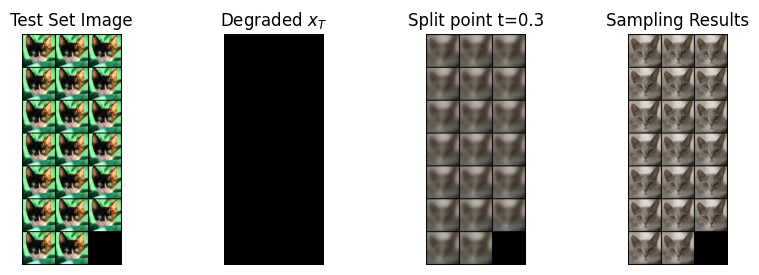

tensor(4.9281e-05)


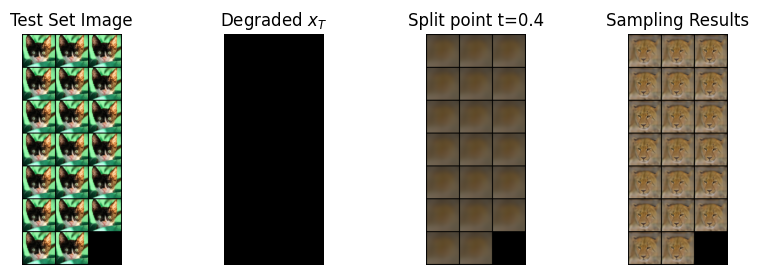

tensor(0.0006)


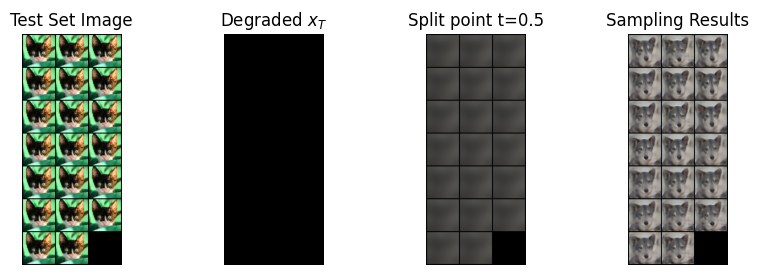

tensor(0.0003)


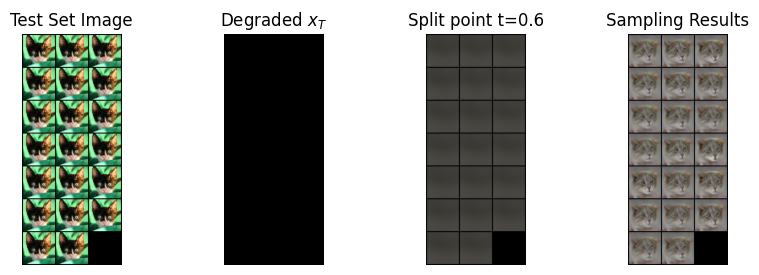

tensor(0.0008)


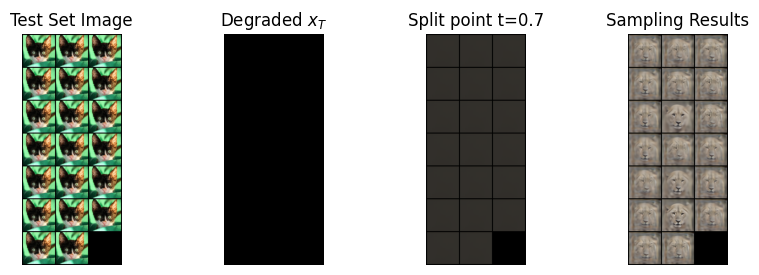

tensor(0.0090)


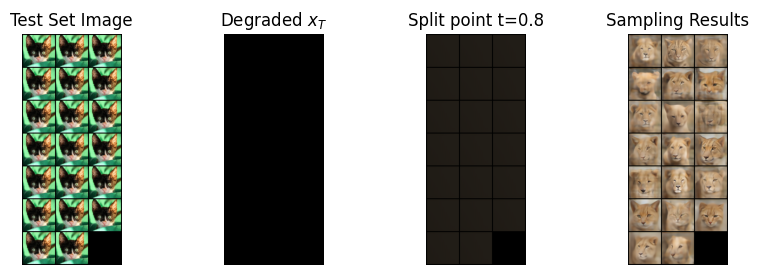

tensor(0.0105)


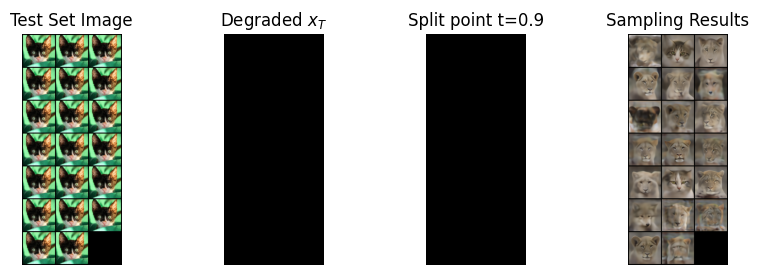

tensor(0.0165)


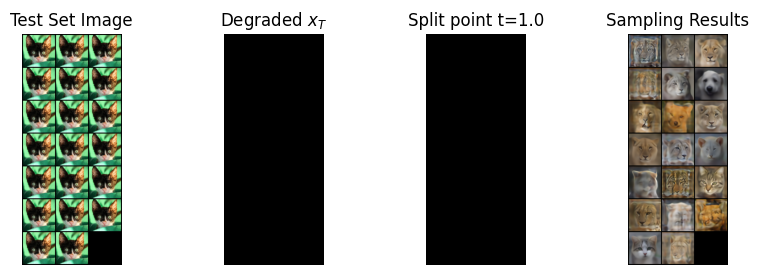

In [32]:
n_images = 20
tm = True
same_initial = original_image[6].unsqueeze(0).repeat(n_images, 1, 1, 1)
z = torch.randn(same_initial.shape[0], config.model.encoder.latent_dim, device=config.device)
# use same z for all
z = z[0].unsqueeze(0).repeat(n_images, 1)
print("Resampled z")
for split_t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:

    t = torch.ones(same_initial.shape[0], device=config.device)
    degraded = degrader(same_initial, t)
    result = model_evaluation_fn(degraded, None, t, z)

    config.model.K = config.model.K
    with torch.no_grad():
        # sampling
        # while any t is not zero
        x = degraded.clone()
        x0 = result.clone()
        while torch.any(t >= 0):
            z = torch.randn(same_initial.shape[0], config.model.encoder.latent_dim, device=config.device)
            # split at t=0.5
            if torch.any(t > split_t):
                z = z[0].unsqueeze(0).repeat(n_images, 1)
                split_point = x.clone()
            x0 = model_evaluation_fn(x, None, t, z)
            if tm:
                x[t>0] = x0[t>0]
            else:
                x[t>0] = x[t>0] - degrader(x0[t>0], t[t>0]) + degrader(x0[t>0], t[t>0] - 1/config.model.K)
            t = t - 1/config.model.K
        sampling_image = x
        print(sampling_image.var(dim=0).mean())
        # caluclate average variance per pixel (averaged over channels)
        # calculate variance per pixel over the batch
        variance = torch.var(sampling_image, dim=0)

    og_grid = make_grid(same_initial, nrow=3)
    degraded_grid = make_grid(degraded, nrow=3)
    result_grid = make_grid(split_point, nrow=3)
    sampling_grid = make_grid(sampling_image, nrow=3)

    # Plot all four images
    fig, axs = plt.subplots(1, 4, figsize=(10, 3))
    axs[0].imshow(og_grid.permute(1, 2, 0))
    axs[0].set_title('Test Set Image')
    axs[1].imshow(degraded_grid.permute(1, 2, 0))
    axs[1].set_title(r'Degraded $x_T$')
    axs[2].imshow(result_grid.permute(1, 2, 0))
    axs[2].set_title(f'Split point t={split_t}')
    axs[3].imshow(sampling_grid.permute(1, 2, 0))
    axs[3].set_title('Sampling Results')
    # Hide the axis for all subplots
    for ax in axs:
        ax.axis('off')
    #plt.title(f'K={config.model.K}')
    plt.show()

tensor(0.0001)

In [201]:
# average color per image
average_color = x.mean(dim=(2, 3)).mean(dim=1)
average_color
original_image[2].mean()

tensor(0.4027)

Mean image color: tensor([0.4875, 0.4178, 0.4576, 0.3116, 0.5061, 0.6922, 0.4345, 0.5247, 0.6422])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Mean image color: tensor([0.5316, 0.6416, 0.5337, 0.4930, 0.4822, 0.2459, 0.4363, 0.4596, 0.5536])
Split at t= 1.0


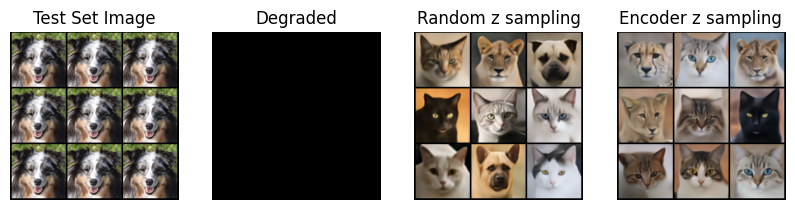

In [222]:
# experiment to compare sampling procedures
z = torch.randn(same_initial.shape[0], config.model.encoder.latent_dim, device=config.device)
same_initial = original_image[2].unsqueeze(0).repeat(9, 1, 1, 1)
same_initial.shape

t = torch.ones(same_initial.shape[0], device=config.device)
degraded = degrader(same_initial, t)
result = model_evaluation_fn(degraded, None, t, z)

# new z for everyone
config.model.K = 20
with torch.no_grad():
    # sampling
    # while any t is not zero
    x = degraded.clone()
    x0 = result.clone()
    while torch.any(t >= 0):
        z = torch.randn(same_initial.shape[0], config.model.encoder.latent_dim, device=config.device)
        x0 = model_evaluation_fn(x, None, t, z)
        x[t>0] = x[t>0] - degrader(x0[t>0], t[t>0]) + degrader(x0[t>0], t[t>0] - 1/config.model.K)
        t = t - 1/config.model.K
    z_sampling_image = x.clone()
print("Mean image color:", x.mean(dim=(2, 3)).mean(dim=1))

# use encoder for z
config.model.K = 100
t = torch.ones(same_initial.shape[0], device=config.device)
with torch.no_grad():
    # sampling
    # while any t is not zero
    x = degraded.clone()
    x0 = result.clone()
    while torch.any(t >= 0):
        x0 = model_evaluation_fn(x, x0, t, None)
        x[t>0] = x[t>0] - degrader(x0[t>0], t[t>0]) + degrader(x0[t>0], t[t>0] - 1/config.model.K)
        t = t - 1/config.model.K
    x0_sampling_image = x.clone()
print("Mean image color:", x.mean(dim=(2, 3)).mean(dim=1))

og_grid = make_grid(same_initial, nrow=3)
degraded_grid = make_grid(degraded, nrow=3)
result_grid = make_grid(z_sampling_image, nrow=3)
sampling_grid = make_grid(x0_sampling_image, nrow=3)

# Load the sampling image
sampling_image = sampling_grid

# Plot all four images
print("Split at t=", split_t)
fig, axs = plt.subplots(1, 4, figsize=(10, 3))
axs[0].imshow(og_grid.permute(1, 2, 0))
axs[0].set_title('Test Set Image')
axs[1].imshow(degraded_grid.permute(1, 2, 0))
axs[1].set_title('Degraded')
axs[2].imshow(result_grid.permute(1, 2, 0))
axs[2].set_title(r'Random z sampling')
axs[3].imshow(sampling_grid.permute(1, 2, 0))
axs[3].set_title('Encoder z sampling')
# Hide the axis for all subplots
for ax in axs:
    ax.axis('off')
plt.show()

For xt style sampling

Resampled z
Mean image color: tensor([0.3941, 0.3938, 0.3934, 0.3937, 0.3946, 0.3935, 0.3934, 0.3936, 0.3936])
Split at t= 0.1


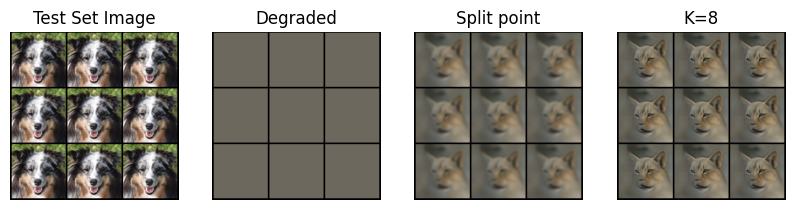

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Mean image color: tensor([0.3926, 0.3914, 0.3924, 0.3925, 0.3927, 0.3922, 0.3907, 0.3914, 0.3926])
Split at t= 0.2


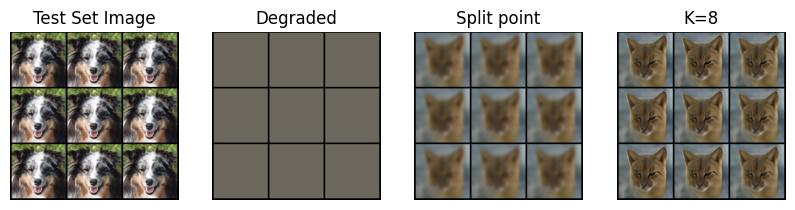

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Mean image color: tensor([0.3936, 0.3941, 0.3946, 0.3929, 0.3938, 0.3942, 0.3938, 0.3927, 0.3948])
Split at t= 0.3


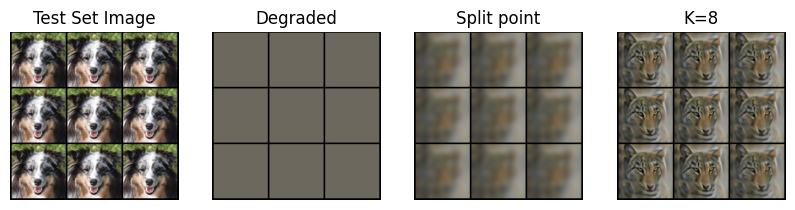

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Mean image color: tensor([0.3925, 0.3929, 0.3913, 0.3932, 0.3919, 0.3937, 0.3924, 0.3939, 0.3940])
Split at t= 0.4


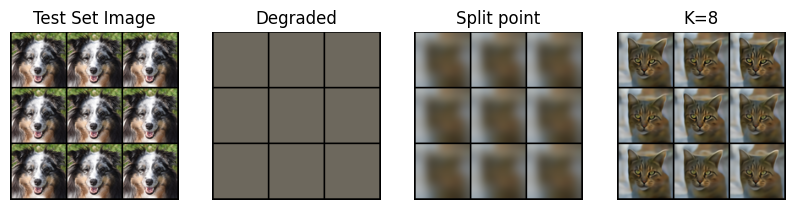

Mean image color: tensor([0.3944, 0.3953, 0.3951, 0.3945, 0.3935, 0.3942, 0.3952, 0.3927, 0.3942])
Split at t= 0.5


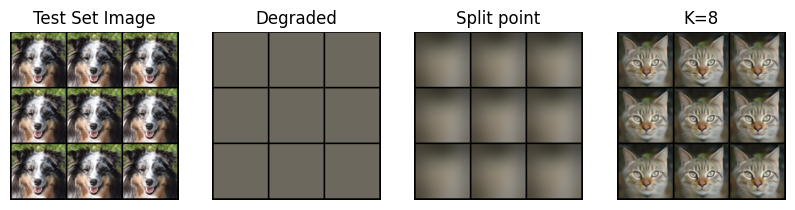

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Mean image color: tensor([0.3934, 0.3940, 0.3945, 0.3946, 0.3945, 0.3944, 0.3921, 0.3941, 0.3948])
Split at t= 0.6


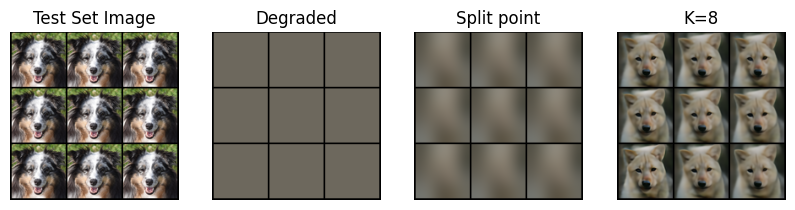

Mean image color: tensor([0.3945, 0.3947, 0.3939, 0.3947, 0.3949, 0.3958, 0.3953, 0.3939, 0.3939])
Split at t= 0.7


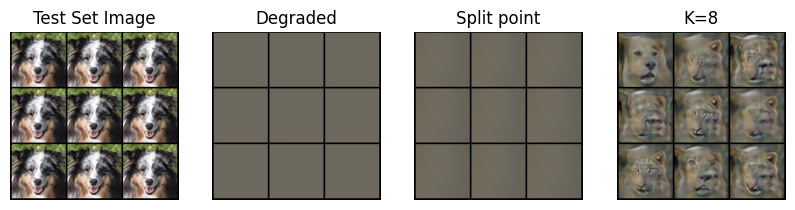

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Mean image color: tensor([0.3954, 0.3942, 0.3949, 0.3958, 0.3973, 0.3959, 0.3975, 0.3958, 0.3949])
Split at t= 0.8


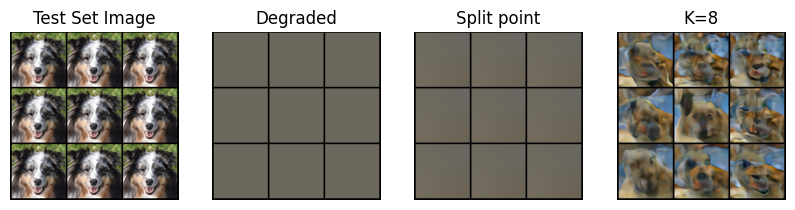

Mean image color: tensor([0.3946, 0.3931, 0.3864, 0.3921, 0.3936, 0.3934, 0.3917, 0.3944, 0.3909])
Split at t= 0.9


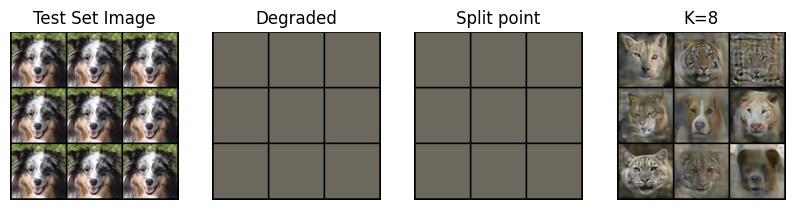

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Mean image color: tensor([0.3965, 0.3922, 0.3940, 0.3923, 0.3936, 0.3944, 0.3944, 0.3930, 0.3946])
Split at t= 0.95


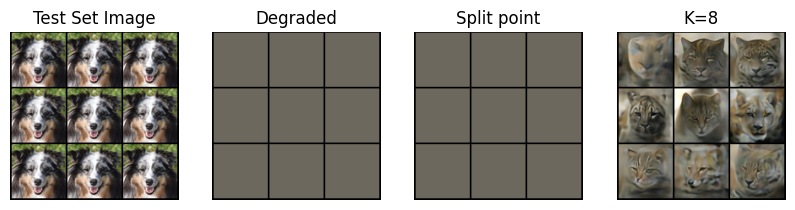

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Mean image color: tensor([0.3948, 0.3946, 0.3968, 0.3960, 0.3938, 0.3969, 0.3959, 0.3957, 0.3947])
Split at t= 0.99


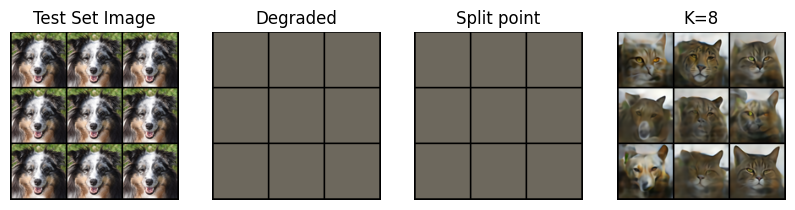

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Mean image color: tensor([0.3896, 0.3936, 0.3930, 0.3949, 0.3918, 0.3946, 0.3918, 0.3919, 0.3928])
Split at t= 1.0


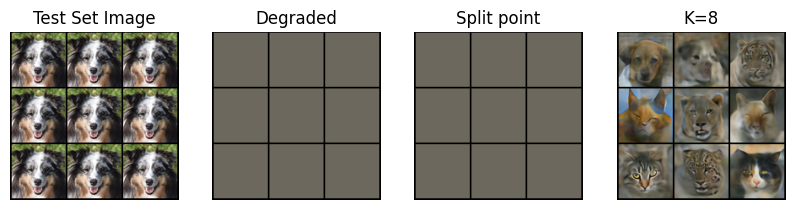

In [231]:
z = torch.randn(same_initial.shape[0], config.model.encoder.latent_dim, device=config.device)
# use same z for all
z = z[0].unsqueeze(0).repeat(9, 1)
print("Resampled z")
for split_t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.0]:
    # use same original image for all
    same_initial = original_image[2].unsqueeze(0).repeat(9, 1, 1, 1)
    same_initial.shape

    t = torch.ones(same_initial.shape[0], device=config.device)
    degraded = degrader(same_initial, t)
    result = model_evaluation_fn(degraded, None, t, z)

    with torch.no_grad():
        # sampling
        # while any t is not zero
        x = degraded.clone()
        x0 = result.clone()
        while torch.any(t >= 0):
            z = torch.randn(same_initial.shape[0], config.model.encoder.latent_dim, device=config.device)
            # split at t=0.5
            if torch.any(t > split_t):
                z = z[0].unsqueeze(0).repeat(9, 1)
                split_point = x.clone()
            x = model_evaluation_fn(x, None, t, z)
            t = t - 1/config.model.K
        sampling_image = x
    print("Mean image color:", x.mean(dim=(2, 3)).mean(dim=1))

    og_grid = make_grid(same_initial, nrow=3)
    degraded_grid = make_grid(degraded, nrow=3)
    result_grid = make_grid(split_point, nrow=3)
    sampling_grid = make_grid(sampling_image, nrow=3)

    # Load the sampling image
    sampling_image = sampling_grid

    # Plot all four images
    print("Split at t=", split_t)
    fig, axs = plt.subplots(1, 4, figsize=(10, 3))
    axs[0].imshow(og_grid.permute(1, 2, 0))
    axs[0].set_title('Test Set Image')
    axs[1].imshow(degraded_grid.permute(1, 2, 0))
    axs[1].set_title('Degraded')
    axs[2].imshow(result_grid.permute(1, 2, 0))
    axs[2].set_title(r'Split point')
    axs[3].imshow(sampling_image.permute(1, 2, 0))
    axs[3].set_title('Sampling Results')
    # Hide the axis for all subplots
    for ax in axs:
        ax.axis('off')
    plt.title(f'K={config.model.K}')
    plt.show()